In [ ]:

import dask.dataframe as dd
from pathlib import Path

import numpy as np
import pandas as pd


def downcast_partition(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        if np.issubdtype(df[col].dtype, np.integer):
            df[col] = pd.to_numeric(df[col], downcast="integer")
        elif np.issubdtype(df[col].dtype, np.floating):
            df[col] = pd.to_numeric(df[col], downcast="float")  # float32 instead of float64
    return df

base_path = Path("/home/haasehelen/haasehelen/ifwaste/output")
EXCLUDE_COLUMNS = ['n_quickcook', 'n_cook', 'n_attempted_cook', 'n_leftovers', 'n_shop',
                   'n_quickshop', 'n_attempted_shop']

scenario_folders = [
    "scenario0_no_promotions", 
    "scenario1_bogos_only", 
    "scenario2_sales_only", 
    "scenario3_both"
]

all_general = []
all_bought = []

for scenario in scenario_folders:
    scenario_path = base_path / scenario
    combined_rows = []
    combined_bought = []  # Collect all bought DataFrames per run
    print(scenario_path)
    
    for run_folder in sorted(scenario_path.glob("run_*"), key=lambda x: int(x.name.split("_")[1])):
        run_id = run_folder.name.split("_")[1]
        
        config_file = run_folder / "log_hh_config.csv"
        output_file = run_folder / "aggregated_outputs.csv"
        bought_file = run_folder / "log_bought.csv"

        if not config_file.exists() or not output_file.exists() or not bought_file.exists():
            print(f"Skipping {run_folder} due to missing files.")
            continue
        
        try:
            df_config = dd.read_csv(config_file)
            df_config["household"] = df_config["household"].astype(int)
            df_config = df_config.map_partitions(downcast_partition)
            df_output = dd.read_csv(output_file)
            df_output["household"] = df_output["household"].astype(int)
            df_output = df_output.map_partitions(downcast_partition)
            df_bought = dd.read_csv(bought_file)
            df_bought["household"] = df_bought["household"].astype(int)
            df_bought = df_bought.map_partitions(downcast_partition)
        except Exception as e:
            print(f"Error reading files in {run_folder}: {e}")
            continue

        merged_df = dd.merge(df_config, df_output, on="household", how="inner")

        # Add unique key — use vectorized string concatenation via assign + map_partitions
        merged_df = merged_df.assign(run_household_key=merged_df["household"].map_partitions(
            lambda s,rid=run_id: "run_" + rid + "_" + s.astype(str)
        ))
        merged_df = merged_df.drop(columns=EXCLUDE_COLUMNS, errors='ignore')
        merged_df = merged_df.map_partitions(lambda df, sc=scenario: df.assign(scenario=sc))
        combined_rows.append(merged_df)

        # For bought, add run_household_key similarly
        df_bought = df_bought.assign(run_household_key=df_bought["household"].map_partitions(
            lambda s, rid=run_id: "run_" + rid + "_" + s.astype(str)
        ))
        df_bought = df_bought.map_partitions(lambda df, sc=scenario: df.assign(scenario=sc))
        combined_bought.append(df_bought)
    
    if combined_rows:
        all_general.extend(combined_rows)
        all_bought.extend(combined_bought)
        print(f"{scenario}: Combined {len(combined_rows)} runs.")
    else:
        print(f"{scenario}: No valid data found.")

general = dd.concat(all_general, interleave_partitions=True)
bought = dd.concat(all_bought, interleave_partitions=True)

/home/haasehelen/haasehelen/ifwaste/output/scenario0_no_promotions
scenario0_no_promotions: Combined 16 runs.
/home/haasehelen/haasehelen/ifwaste/output/scenario1_bogos_only
scenario1_bogos_only: Combined 16 runs.
/home/haasehelen/haasehelen/ifwaste/output/scenario2_sales_only
scenario2_sales_only: Combined 16 runs.
/home/haasehelen/haasehelen/ifwaste/output/scenario3_both
scenario3_both: Combined 16 runs.


## 1) How much do agents buy based on the scenario? -> Servings

In [2]:
DAYS = 114

In [3]:
num_household = bought["run_household_key"].nunique().compute()

In [4]:
num_household

np.int64(8000)

In [5]:
# add new columns total_servings = amount * servings
# sort by scenario
bought["total_servings"] = bought["amount"] * bought["servings"]
serv_per_scenario = bought.groupby("scenario")["total_servings"].sum()
servings_per_scenario = serv_per_scenario.compute()
servings_per_scenario = (servings_per_scenario.astype(float)).round(1)  # convert to float
servings_per_scenario /= (DAYS * num_household)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_by_scenario(dd):
    dd = dd.reindex(scenario_folders)
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=dd.index,
        y=dd.values,
        palette="viridis",
        hue = dd.index, 
        legend=False
    )
    plt.xlabel("Scenario", fontsize=12)
    plt.ylabel("adjust", fontsize=12)
    # Add labels above bars
    for i, val in enumerate(dd.values):
        plt.text(i, val, f"{val.round(2)}", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


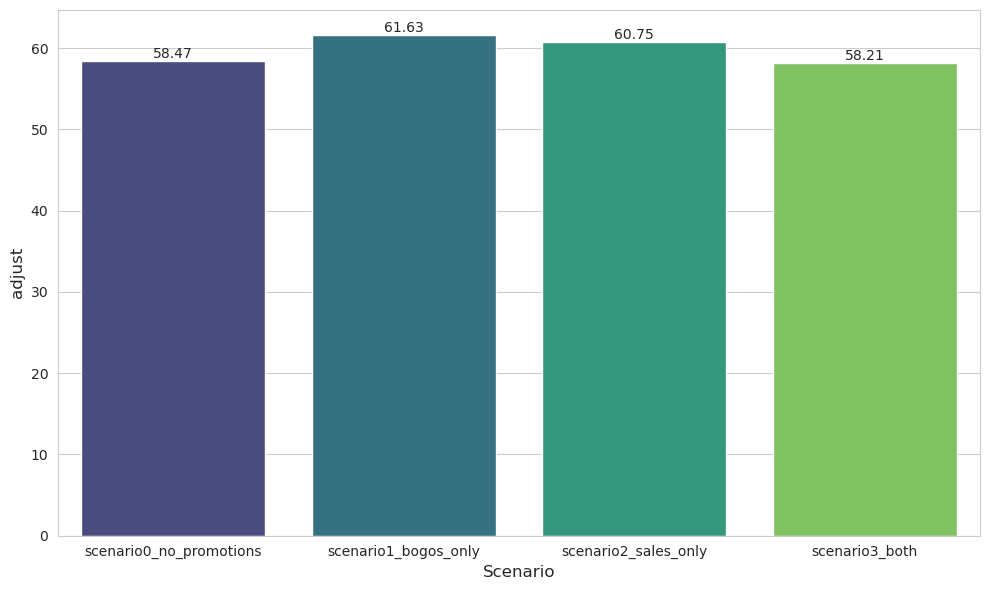

In [31]:
plot_by_scenario(servings_per_scenario)

In [7]:
# add new columns total_servings = amount * servings
# sort by scenario
bought["cost"] = bought["total_servings"] * bought["price_per_serving"]
by_cost = bought.groupby("scenario")["cost"].sum()
by_cost = by_cost.compute()
by_cost = by_cost.astype(float)  # convert to float
by_cost = (by_cost/((DAYS * num_household))).round(2)



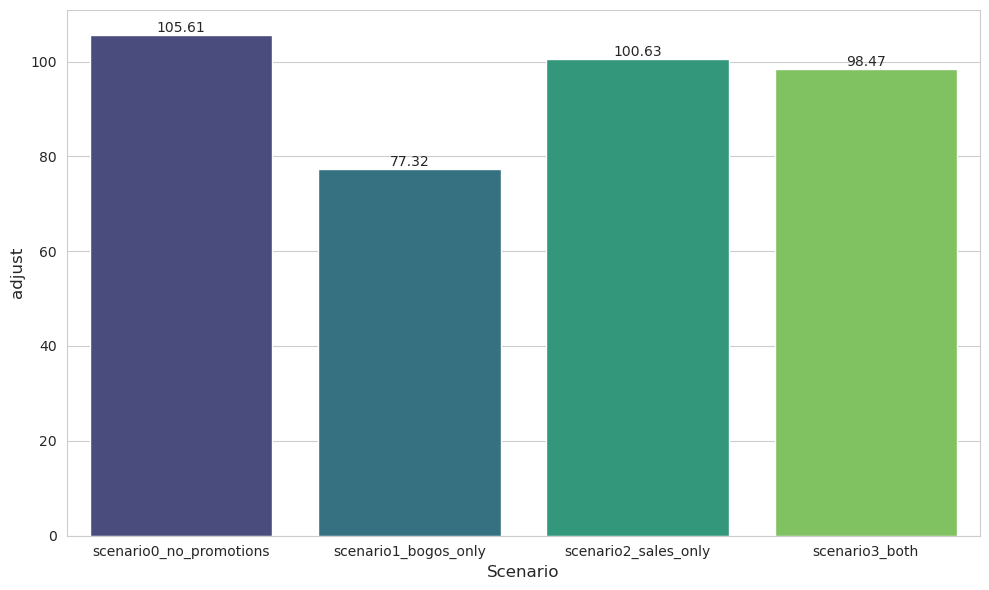

In [8]:
plot_by_scenario(by_cost)

In [9]:
bought['cost'] = bought['servings'] * bought['price_per_serving'] * bought["amount"]
by_sale_type = bought.groupby(['scenario', 'sale_type'])['cost'].sum()

by_sale_type_df = by_sale_type.compute().reset_index()
by_sale_type_df = pd.DataFrame(by_sale_type_df)
by_sale_type_df["cost"] = (by_sale_type_df["cost"]/((DAYS * num_household))).round(2)


In [10]:
by_sale_type_df

,scenario,sale_type,cost
0,scenario1_bogos_only,EnumSales.NONE,38.290001
1,scenario1_bogos_only,EnumSales.EXPIRING,27.280001
2,scenario1_bogos_only,EnumSales.SEASONAL,11.750000
3,scenario3_both,EnumSales.EXPIRING,38.360001
4,scenario3_both,EnumSales.SEASONAL,18.920000
5,scenario0_no_promotions,EnumSales.NONE,105.610001
6,scenario2_sales_only,EnumSales.NONE,39.630001
7,scenario3_both,EnumSales.NONE,41.180000
8,scenario2_sales_only,EnumSales.EXPIRING,34.570000
9,scenario2_sales_only,EnumSales.SEASONAL,26.430000


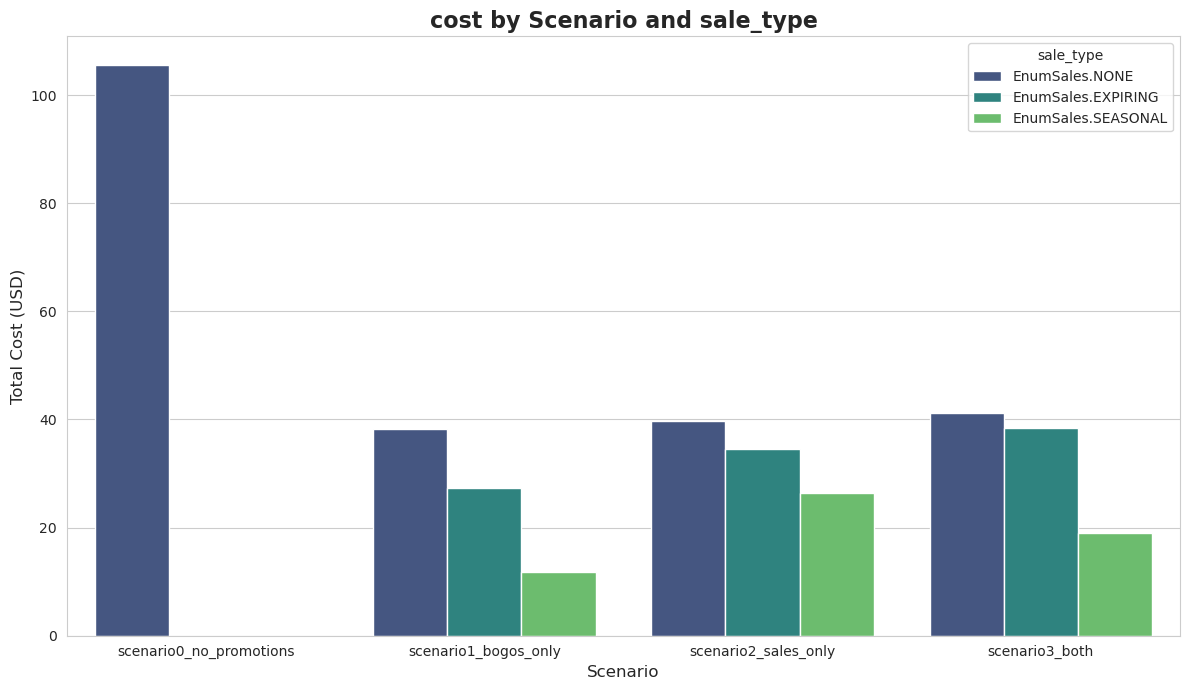

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_by_two_variables(data, y, groups):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 7))

    sns.barplot(
        x='scenario',
        y=y,
        hue=groups,
        data=data,
        palette='viridis',
        order=scenario_folders,  # control x-axis order
        ax=ax
    )

    ax.set_xlabel('Scenario', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_by_two_variables(by_sale_type_df, y='cost', groups='sale_type')


In [17]:
type(bought)

dask_expr._collection.DataFrame

In [18]:
# Add a simplified 'store_type' column
bought = bought.map_partitions(
    lambda df: df.assign(store_type=df['store'].str.split(' ').str[0])
)
by_store_type = bought.groupby(['scenario', 'store_type'])['cost'].sum()
by_store_type_df = by_store_type.compute().reset_index()


In [20]:
by_store_type_df["cost"] = (by_store_type_df["cost"]/((DAYS * num_household))).round(2)

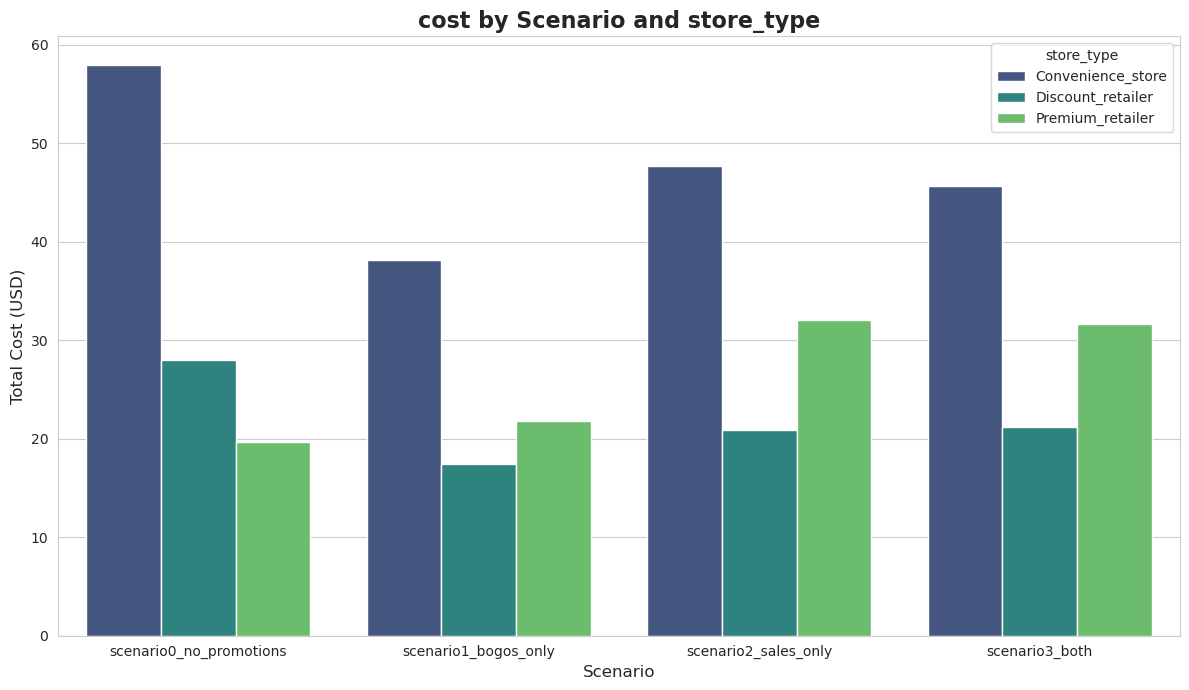

In [ ]:
plot_by_two_variables(by_store_type_df, y='cost', groups='store_type')

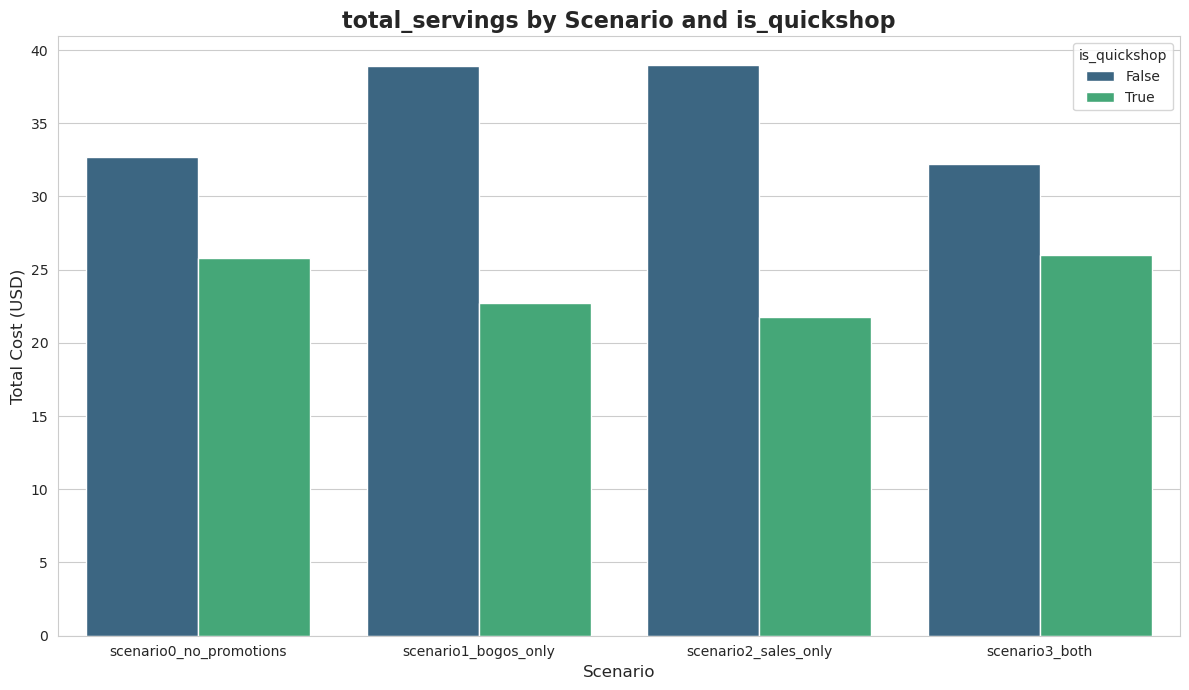

In [ ]:
quickshop = bought.groupby(['scenario', 'is_quickshop'])['total_servings'].sum()

quickshop_df = quickshop.compute().reset_index()
quickshop_df = pd.DataFrame(quickshop_df)
quickshop_df["total_servings"] = (quickshop_df["total_servings"]/((DAYS * num_household))).round(2)


In [ ]:
plot_by_two_variables(quickshop_df, y='total_servings', groups='is_quickshop')

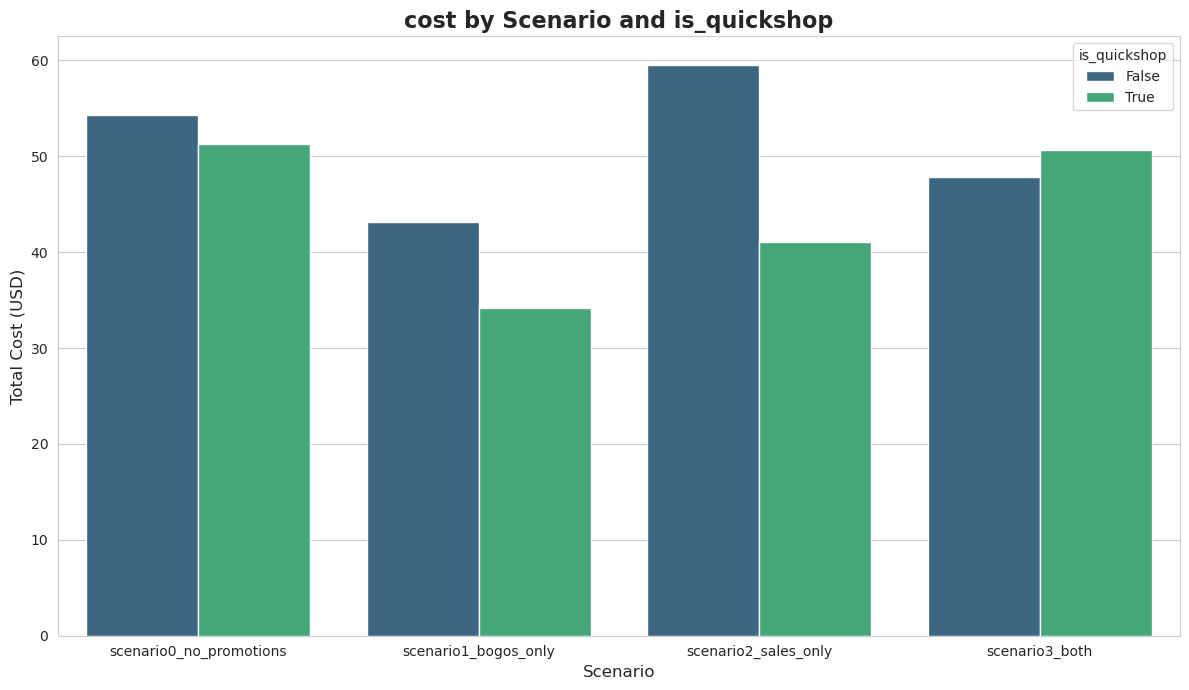

In [ ]:
quickshop = bought.groupby(['scenario', 'is_quickshop'])['cost'].sum()

quickshop_df = quickshop.compute().reset_index()
quickshop_df = pd.DataFrame(quickshop_df)
quickshop_df["cost"] = (quickshop_df["cost"]/((DAYS * num_household))).round(2)



In [ ]:

plot_by_two_variables(quickshop_df, y='cost', groups='is_quickshop')

ValueError: Could not interpret value `type` for `hue`. An entry with this name does not appear in `data`.

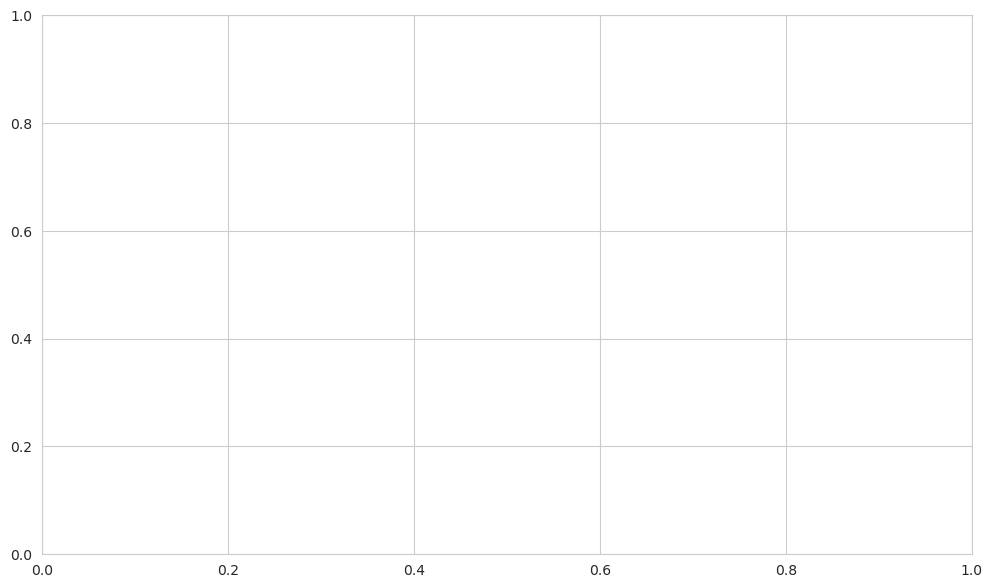

In [ ]:
fg = bought.groupby(['scenario', 'type'])['total_servings'].sum()

fg_df = fg.compute().reset_index()
fg_df = pd.DataFrame(fg_df)
fg_df["total_servings"] = (fg_df["total_servings"]/((DAYS * num_household))).round(2)

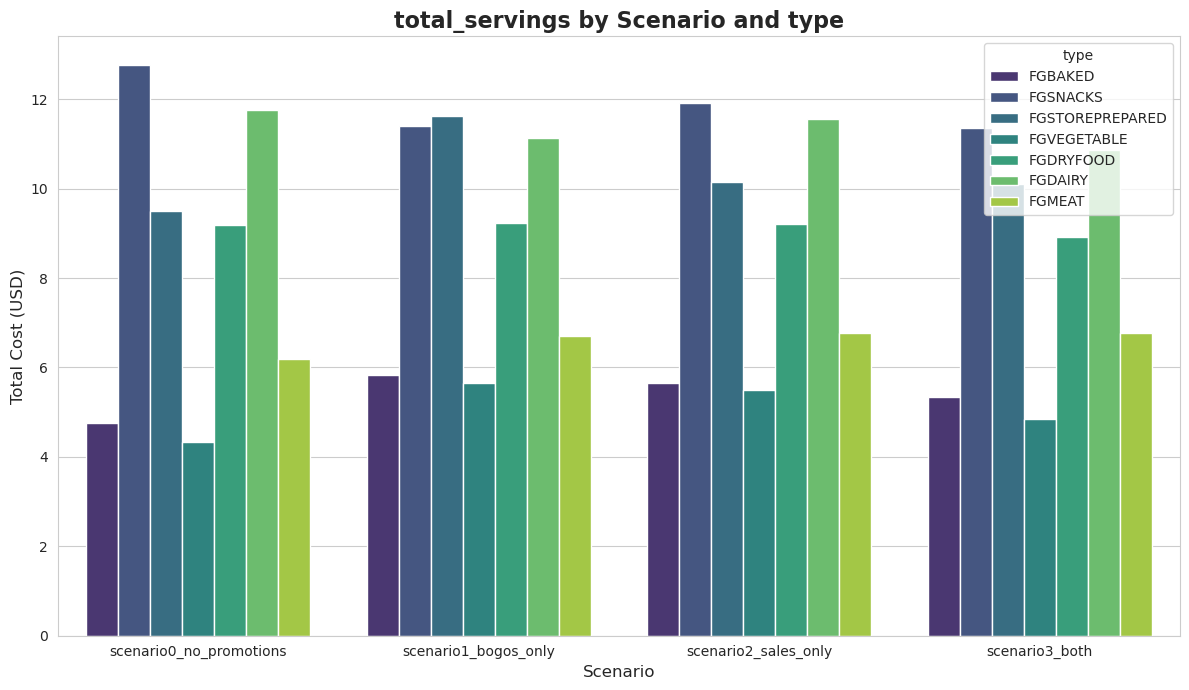

In [39]:
plot_by_two_variables(fg_df, y='total_servings', groups='type')